# Tutorial - Wasserstein GAN

In [306]:
using Flux
using Statistics, Distributions
using Plots

Suponha que observamos os dados acima e desconhecemos a função que os geraram.
O que queremos então fazer é criar uma rede neural que gera dados
dessa distribuição, onde temos acesso somente a essas amostras.

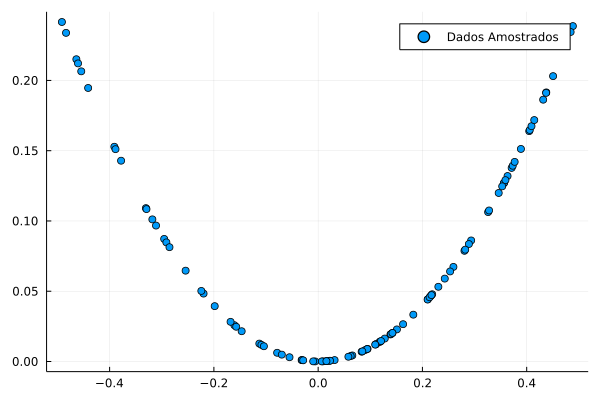

In [307]:
function generate_real_data(n)
    x1 = rand(1,n) .- 0.5
    x2 = x1 .* x1
    return vcat(x1,x2)
end

dados = generate_real_data(100)
x,y = dados[1,:], dados[2,:]
scatter(x,y, label="Dados Amostrados")

### Construindo o Discriminador e o Gerador

In [308]:
function D()
    return Chain(
            Dense(2, 25,relu),
            Dense(25,1)
            )
end

function G(latent_dim::Int)
    return Chain(
            Dense(latent_dim, 15,relu),
            Dense(15,2)
            )
end;


A WGAN busca resolver o seguinte problema de otimização:

$$
\min_{G} \max_D V(D,G) =
\mathbb{E}_{P_{data}(x)}\left[\log{(D(x))}\right]+
\mathbb{E}_{P_z(z)}\left[\log(1-D(G(z))\right],
$$

Assim, temos uma função de perda para treinar $D$ e outra para treinara $G$.

In [286]:
loss_D(x, y, dscr) = sum(Flux.Losses.logitbinarycrossentropy(dscr(x), y));

loss_G(z,gen,dscr) = sum(Flux.Losses.logitbinarycrossentropy(dscr(gen(z)),1))

function wasserstein_loss_discr(real,fake, dscr)
    return -mean(dscr(real)) + mean(dscr(fake))
end

function wasserstein_loss_gen(z,gen,dscr)
    return -mean(dscr(gen(z)))
end


wasserstein_loss_gen (generic function with 2 methods)

In [287]:
m = 5
real = generate_real_data(m)
fake = gen(rand(5,m))
wasserstein_loss_discr(real,fake,dscr)
# dscr(gen(rand(5)))
-mean(dscr(real)) + mean(dscr(fake))

0.05370101172803399

### Vamos descrever a função para treinar a rede $D$.

In [292]:
round(Int, 10/4)

2

In [303]:
function trainDiscriminator!(dscr,gen,train_size)
    ps = Flux.params(dscr)
    clip = 0.01
    m = round(Int,train_size/10)
    for n  in 1:5
        real = generate_real_data(m)
        fake = gen(rand(5,m))
        gs = gradient(Flux.params(dscr)) do
            l = wasserstein_loss_discr(real,fake,dscr)
        end
        Flux.update!(opt, Flux.params(dscr), gs)
        for i in ps
            i = clamp.(i, -clip, clip)
        end
    end
end

function trainDiscriminator!(dscr,gen,train_size)
    ps = Flux.params(dscr)
    clip = 0.01
    real = generate_real_data(train_size)
    fake = gen(rand(5,train_size))

    X    = hcat(real,fake)
    Y    = vcat(ones(train_size),zeros(train_size))
    data = Flux.Data.DataLoader((X, Y'), batchsize=1,shuffle=true);
    for d in data
        gs = gradient(Flux.params(dscr)) do
            l = loss_D(d...,dscr)
        end
        Flux.update!(opt, Flux.params(dscr), gs)
        for i in ps
            i = clamp.(i, -clip, clip)
        end
    end
end

function trainGenerator!(gen,dscr,train_size)
    noise = rand(5,train_size)
    data = Flux.Data.DataLoader(noise, batchsize=128,shuffle=true);
    for d in data
        gs = gradient(Flux.params(gen)) do
            l = wasserstein_loss_gen(d,gen,dscr)
        end
        Flux.update!(opt, Flux.params(gen), gs)
    end
    fake_generated = gen(rand(5,train_size))
end

trainGenerator! (generic function with 1 method)

In [304]:
gen  = G(5)
dscr = D()
opt  = ADAM()
# opt  = RMSProp(0.00005)
train_size = 2000

2000

In [305]:
epochs = 200
for e in 1:epochs
    trainDiscriminator!(dscr,gen,Int(train_size))
    trainGenerator!(gen,dscr,train_size)
    if e%100 == 0
        real = generate_real_data(train_size)
        fake = gen(rand(5,train_size))
        @show mean(dscr(real)),mean(dscr(fake))
    end
end

LoadError: InterruptException:

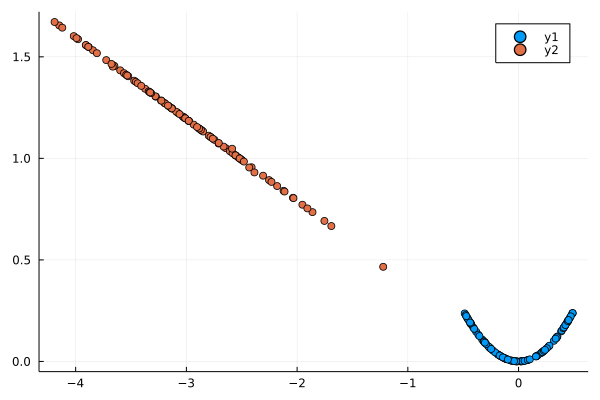

In [302]:
real = generate_real_data(train_size)
fake = gen(rand(5,train_size))
scatter(real[1,1:100],real[2,1:100])
scatter!(fake[1,1:100],fake[2,1:100])